# Ad-hoc network model 
## Imports

In [17]:
import numpy as np
import pandas as pd 
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures as futures
from tqdm.notebook import tqdm
from multiprocessing import Pool


from time import sleep

## Loading data

In [2]:
number_of_datasets = widgets.BoundedIntText(
    text = 1,
    min = 1,
    max = 16,
    step = 1,
    description = "Number of datasets:")

display(number_of_datasets)

BoundedIntText(value=1, description='Number of datasets:', max=16, min=1)

In [3]:
csv_paths = list()
for i in range(number_of_datasets.value):
    csv_paths.append(widgets.Text(placeholder="Path to .csv file"))
    display(csv_paths[i])

Text(value='', placeholder='Path to .csv file')

Text(value='', placeholder='Path to .csv file')

Text(value='', placeholder='Path to .csv file')

Text(value='', placeholder='Path to .csv file')

In [4]:
data = list()

for csv_path in csv_paths:
    data.append(pd.read_csv(csv_path.value))

## Preprocessing

The goal here is to filter redundant objects (for example, objects that are currently chilling in the object pool) and split data into small pieces by the timeframe 

In [5]:
filtered_data = list(map(lambda data: data[data.z != -100.0], data)) # Preserve only the objects that are currently somewhere on the map

# frames = list(map(lambda data: data.groupby('timestamp'), filtered_data)) # Group data into dataframes with equal timestamp, now each group is a snapshot of a moment in time during recording
# group_keys = list(map(lambda frames: frames.groups.keys(), frames)) # Now we can iterate over groups

## Model setup

In [6]:
# TODO widget for parameter initialization
# Proposed parameters are: Connectivity distance, something about message generation frequency, ???
connectivity_dist = widgets.BoundedFloatText(
    text = 0.0,
    min = 0.0,
    max = 1000.0,
    step = 1,
    description = "Distance:",
    disabled = False)

display(connectivity_dist)

BoundedFloatText(value=0.0, description='Distance:', max=1000.0, step=1.0)

## Your actor implementation

In [7]:
# TODO Come up with actor interface 
# TODO implement actor. It should be capable of handling high-level shit like sending message to other use and low-level shit like routing messages inside the network
# Are there obvious and correct implementation of the high-level functions that is irrelevant to the protocol of choice? If there is, we should implement them independently of the algo impl (via inheritance)
class Actor:
    def __init__():
        pass

## Model running

In [18]:
# TODO run model, accumulate some statistics
# Proposed stats are: 
# 1. Connection stability (stability metric could be connection lifetime divided over the simulation length) equipped with standard stat tools (mean, stdev, median, possibly distribution, smth else)
# 2. Stats on message delivery efficiency (percentage of successful deliveries, for instance)

# TODO wrap everything up in a function, possibly use something like futures in order to parallelize computations for different datasets, in order to allow for parallel processing of many datasets in order to speed up the whole thing

# Calculate distance between two people
def distance(p1, p2):
    return ((p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y) + (p1.z - p2.z) * (p1.z - p2.z)) ** (1/2)

# Initialize structures for collecting adjacency data
def process_data(filtered_data):
    print(' ', end='', flush=True) # Hack to allow for multiple progress bars
    
    frames = filtered_data.groupby('timestamp')
    group_keys = frames.groups.keys()
    
    ids = filtered_data['id'].unique() # IDs of users

    def first(i, j):
        return min(ids[i], ids[j])

    def second(i, j):
        return max(ids[i], ids[j])

    # Structure that contains info regarding whether two people were previously connected with one another (Timeframe of connection launch, None otherwise)
    connected = dict()

    for cur_id in ids:
        connected[cur_id] = dict()

    for i in range(len(ids)):
        for j in range(i + 1, len(ids)): # Iterate over the distinct pairs of people
            connected[first(i, j)][second(i, j)] = None # Initialize all pairs as not connected

    # Structure that contains info about each connection (two connections between the same two people are distinct iff there exists a snapshot where they aren't connected)
    # The sequence A <-> B, A <-> B, A <-/-> B, A <-> B contains two connections between A and B
    connections = list() 
    prev_timestamp = 0

    # Nested loops go brrrr (Can we parallelize this piece of shit? Even a little bit?)
    for timestamp in tqdm(group_keys): # Iterating over timestamp
        # TODO calculate connections between different people in the current timeframe
        snapshot = frames.get_group(timestamp) # Get a snapshot of a timestamp

        current_connectivity = dict()
        for cur_id in ids:
            current_connectivity[cur_id] = dict()

        for i in range(len(ids)):
            for j in range(i + 1, len(ids)):
                current_connectivity[first(i, j)][second(i, j)] = False


        for i in range(snapshot.shape[0]):
            for j in range(i + 1, snapshot.shape[0]): # Iterate over distinct ordered pairs of people 
                p1 = snapshot.iloc[i]
                p2 = snapshot.iloc[j]
                dist = distance(p1, p2)
                if dist < connectivity_dist.value: # If there is connection present
                    current_connectivity[min(p1.id, p2.id)][max(p1.id, p2.id)] = True # Mark it is connected

        for i in range(len(ids)):
            for j in range(i + 1, len(ids)):
                a = first(i, j)
                b = second(i, j)

                if current_connectivity[a][b]: # If a connection is present 
                    if connected[a][b] is None: # And it is a new one
                        connected[a][b] = timestamp # Add it
                elif connected[a][b] is not None: # Otherwise, if the conneciton had just died 
                    connections.append({'p1': a, 'p2': b, 'timestamp': connected[a][b], 'lifespan': prev_timestamp - connected[a][b]}) # Record connection stats
                    current_connectivity[a][b] = None # Delete connection
        # Now iterate over all the ids in order to figure out the connections that were dropped out 

        # TODO check for new/removed connections and update lifetime accordingly
        # TODO run shit like message requests etc and call according functions of the actors
        # Possibly (somehow?) add message throughput limit so that the graph updates would actually influence message routing procedure. Should prolly discuss the best implementation with other project participants.
        prev_timestamp = timestamp
        pass

    # Close all the connections that are still present
    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            a = first(i, j)
            b = second(i, j)

            if connected[a][b] is not None:
                connections.append({'p1': a, 'p2': b, 'timestamp': connected[a][b], 'lifespan': prev_timestamp - connected[a][b]}) # Record connection stats
    #             print("Added connection info")
                connected[a][b] = None
        
    return pd.DataFrame(connections)

conn_datas = list()
# for i in range(number_of_datasets.value):
#     conn_datas.append(process_data(filtered_data[i], frames[i], group_keys[i]))

conn_datas_promise = list()

# with futures.ThreadPoolExecutor(max_workers=4) as e:
#     for i in range(number_of_datasets.value):
#         conn_datas_promise.append(e.submit(process_data, filtered_data[i], frames[i], group_keys[i]))

In [38]:
pool = Pool(4)

  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/621 [00:00<?, ?it/s]

  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

In [39]:
res = pool.map(process_data, filtered_data)

In [40]:
res

[            p1      p2  timestamp  lifespan
 0       168194  536322          0         0
 1       535298  543490          0         0
 2       169730  544002          0       516
 3        14082  168194          0       516
 4        14338  168194          0       516
 ...        ...     ...        ...       ...
 872976   26115  773122     310715      4085
 872977   17667  773122     310715      4085
 872978   13059   13827     311236      3564
 872979   13059   26883     311236      3564
 872980   13827   26883     311236      3564
 
 [872981 rows x 4 columns],
             p1      p2  timestamp  lifespan
 0         9986   11266          0         0
 1        12034   13826          0         0
 2        13826   18946          0         0
 3         7426   13314          0       516
 4         9986   11266          0       516
 ...        ...     ...        ...       ...
 805184  128258  129026     309922      3024
 805185  128258  129282     310436      2510
 805186  128770  129026  

#### Statistics

In [ ]:
# TODO Show collected stats 
conn_data = conn_datas[3]


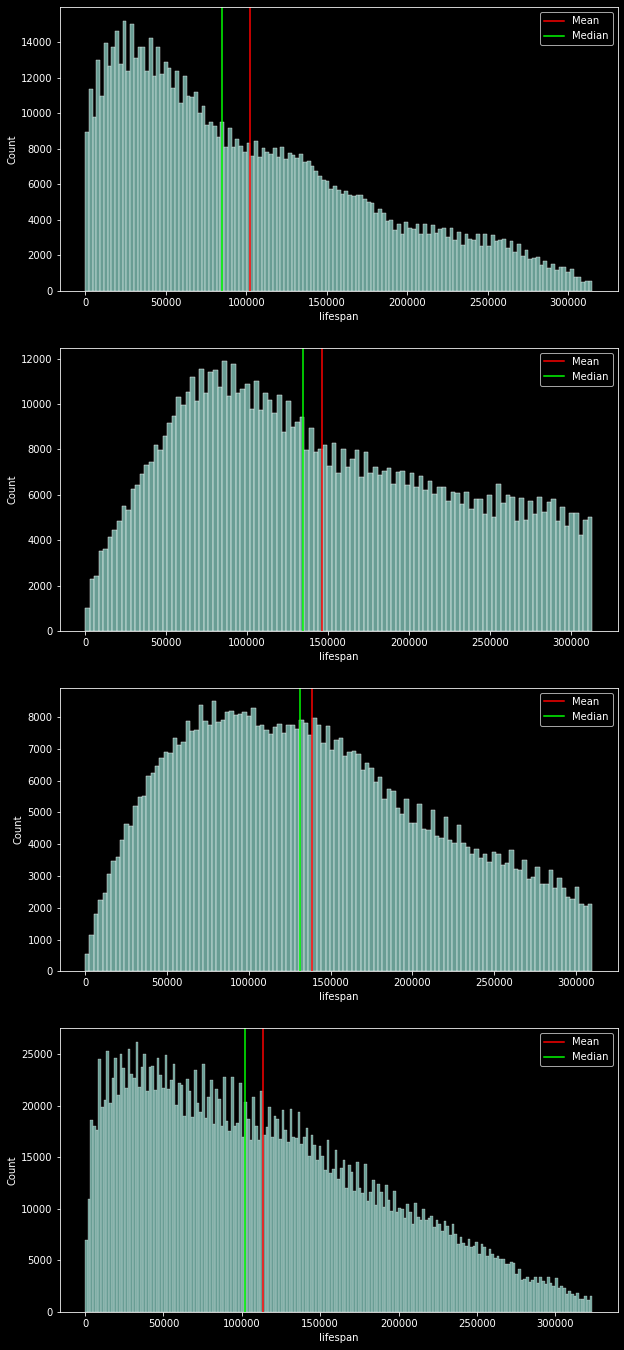

In [49]:
plt.style.use("dark_background")
fig, axs = plt.subplots(4, figsize=(10, 24))

for i in range(len(res)):
    mean_lifespan = res[i]['lifespan'].mean()
    median_lifespan = res[i]['lifespan'].median()
    stdev_lifespan = res[i]['lifespan'].std()

    sns.histplot(res[i], x="lifespan", ax=axs[i])

    axs[i].axvline(mean_lifespan, color="r", label="Mean")
    axs[i].axvline(median_lifespan, color="lime", label="Median")
    axs[i].legend()

#     print("Mean lifespan:", mean_lifespan)
#     print("lifespan stdev:", stdev_lifespan)



In [36]:
conn_datas

[]

In [ ]:
conn_data[conn_data.lifespan == 50000].size

In [ ]:
conn_data

In [ ]:
101012/314800

In [ ]:
len(ids)

In [ ]:
a = list()
a.append(10)

In [ ]:
a